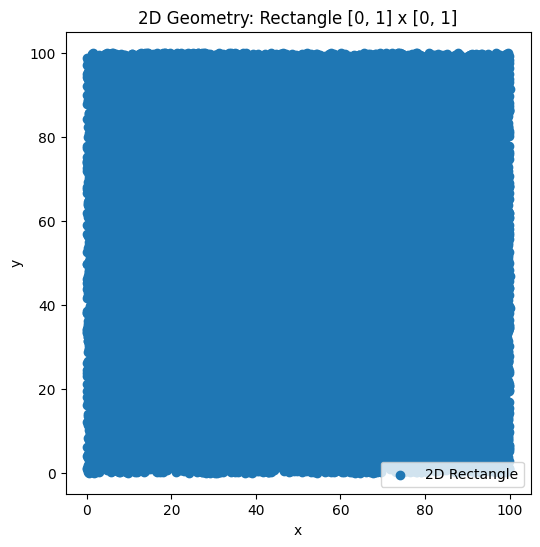

Compiling model...
Building feed-forward neural network...
'build' took 0.052984 s



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.304307 s

Training model...

0         [1.56e+12, 3.30e+12, 1.97e+13, 2.05e-03, 5.10e-02]    [1.21e+12, 9.22e+11, 2.69e+13, 2.05e-03, 5.10e-02]    []  
1000      [1.40e+12, 2.87e+12, 1.70e+13, 3.25e-03, 5.02e-02]    [1.17e+12, 8.54e+11, 2.31e+13, 3.25e-03, 5.02e-02]    []  
2000      [1.27e+12, 2.51e+12, 1.47e+13, 5.87e-03, 4.93e-02]    [1.13e+12, 7.93e+11, 1.99e+13, 5.87e-03, 4.93e-02]    []  
3000      [1.17e+12, 2.18e+12, 1.26e+13, 9.71e-03, 4.83e-02]    [1.10e+12, 7.35e+11, 1.70e+13, 9.71e-03, 4.83e-02]    []  
4000      [1.08e+12, 1.89e+12, 1.08e+13, 1.46e-02, 4.73e-02]    [1.07e+12, 6.82e+11, 1.44e+13, 1.46e-02, 4.73e-02]    []  
5000      [1.01e+12, 1.62e+12, 9.14e+12, 2.04e-02, 4.64e-02]    [1.03e+12, 6.31e+11, 1.21e+13, 2.04e-02, 4.64e-02]    []  
6000      [9.48e+11, 1.39e+12, 7.68e+12, 2.68e-02, 4.55e-02]    [9.99e+11, 5.84e+11, 1.00e+13, 2.68e-02, 4.55e-02]    []  
7000      [9.01e+11, 1.18e+12, 6.41e+12, 3.36e-02, 4.46e-02]    [9.62e+11, 5.39e+11, 8.23e+12

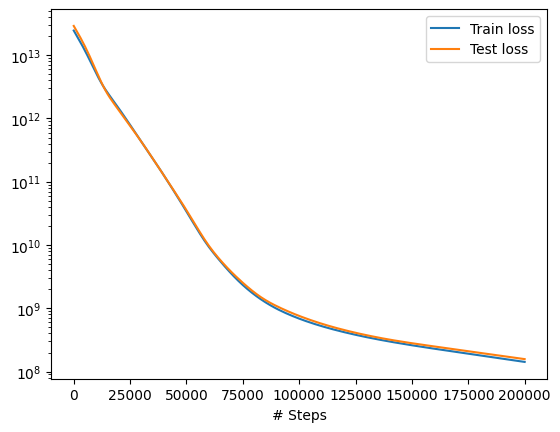

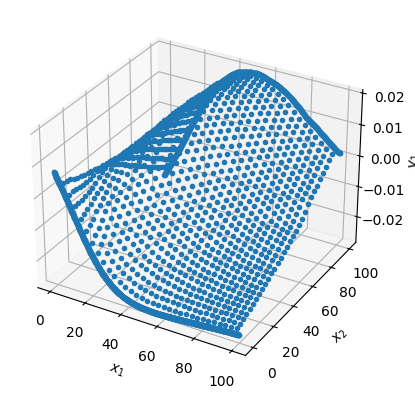

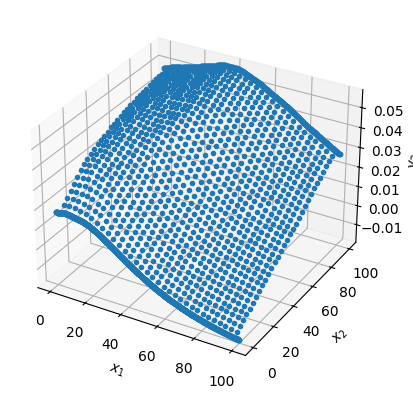

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import deepxde as dde
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, r2_score
traction=1e5 
E=2e8
L =100 # mm
nu=0.3
qx=0
qy=0
square = dde.geometry.Rectangle([0, 0], [L, L])
geom = square


# Sample points in the geometry
Samp = geom.random_points(30000)

# Visualize the geometry
plt.figure(figsize=(6, 6))
plt.scatter(Samp[:, 0], Samp[:, 1], marker='o', label="2D Rectangle")
plt.title("2D Geometry: Rectangle [0, 1] x [0, 1]")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], L)
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)



def traction_top(x, y,X):
 

    # Compute derivatives
    duxdx = dde.grad.jacobian(y, x, i=0, j=0)  # ∂u_x/∂x
    duxdy = dde.grad.jacobian(y, x, i=0, j=1)  # ∂u_x/∂y
    duydx = dde.grad.jacobian(y, x, i=1, j=0)  # ∂u_y/∂x
    duydy = dde.grad.jacobian(y, x, i=1, j=1)  # ∂u_y/∂y

    # Strain components
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy

    # Traction components on top boundary
    T_x = sigma_xy  # Since n_x = 0, T_x = σ_xy n_y
    T_y = sigma_yy  # Since n_y = 1, T_y = σ_yy n_y

    # Desired traction
    T_x_desired = 0
    T_y_desired = traction  # 1e5 Pa
    T_x_residual = T_x - T_x_desired
    T_y_residual = T_y - T_y_desired    


    residuals = tf.concat([T_x - T_x_desired, T_y - T_y_desired], axis=1)
    return [residuals]


bc_bottom_u_x = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=0)
bc_bottom_u_y = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
bc_top_sigma=dde.OperatorBC(geom, traction_top, boundary_top)


def pde(x, y):
    
    ux=y[:,0:1]
    uy=y[:,1:2]

    C = (E / (1 - nu**2)) * np.array([[1, nu, 0],
                                      [nu, 1, 0],
                                      [0, 0, (1 - nu) / 2]])
    
    duxdx=dde.grad.jacobian(y,x,i=0,j=0)
    duxdy=dde.grad.jacobian(y,x,i=0,j=1)
    duydx=dde.grad.jacobian(y,x,i=1,j=0)
    duydy=dde.grad.jacobian(y,x,i=1,j=1)
    #Strain
    eps_xx = duxdx
    eps_yy = duydy
    gamma_xy = duxdy + duydx

    # Constitutive relations residuals
    sigma_xx = (E / (1 - nu ** 2)) * (eps_xx + nu * eps_yy)
    sigma_yy = (E / (1 - nu ** 2)) * (eps_yy + nu * eps_xx)
    sigma_xy = (E / (2 * (1 + nu))) * gamma_xy
    
    # Equilibrium equations
    sigma_xx_x = dde.grad.jacobian(sigma_xx, x, i=0, j=0)
    sigma_xy_y = dde.grad.jacobian(sigma_xy, x, i=0, j=1)
    sigma_xy_x = dde.grad.jacobian(sigma_xy, x, i=0, j=0)
    sigma_yy_y = dde.grad.jacobian(sigma_yy, x, i=0, j=1)
    
    eq1 = sigma_xx_x + sigma_xy_y + qx
    eq2 = sigma_xy_x + sigma_yy_y + qy
    
    return [eq1, eq2]

data = dde.data.PDE(
    geom,
    pde, [bc_top_sigma, bc_bottom_u_x, bc_bottom_u_y],
    num_domain=3000,
    num_boundary=2000,
    num_test=1000,
    )

# Network for C_L
layer_size = [2] + [62] * 5 + [2]  
activation = "tanh"
initializer = "Glorot uniform"
net_C_L = dde.nn.FNN(layer_size, activation, initializer)

model= dde.Model(data, net_C_L)

model.compile("adam", lr=1e-4)
# Define the model with the PDE, initial and boundary conditions

# Add the callback when training the model
losshistory, train_state = model.train(epochs=200000, display_every=1000)

# Optionally plot and save results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [62]:
Test = model.predict([[0,0]])
print(Test)

[[-0.01174407  0.00798918]]


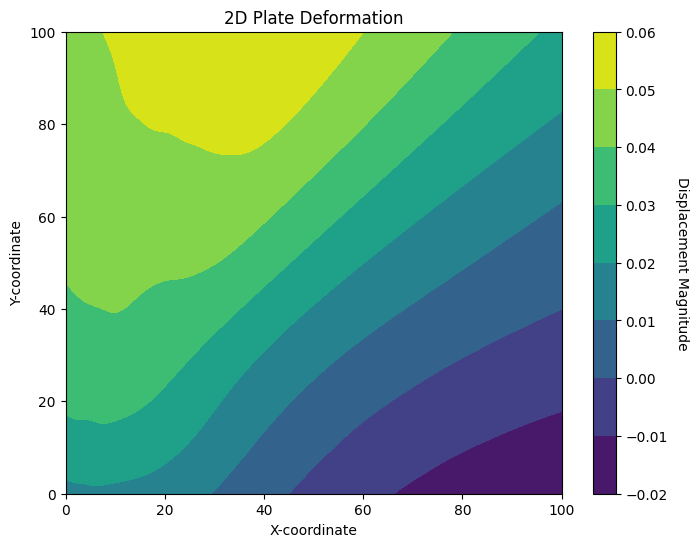

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model has already been trained
# Now you can generate test points in the geometry and evaluate the solution

# Generate a grid of points in the geometry (replace this with your actual grid)
x_test = np.linspace(0, L, 3000)  # x-coordinates
y_test = np.linspace(0, L, 3000)  # y-coordinates
x_grid, y_grid = np.meshgrid(x_test, y_test)  # Create a mesh grid

# Flatten the grid points into a list of coordinates
test_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Predict displacements using the trained model
u_pred = model.predict(test_points)

# Extract the x and y displacements from the predictions
u_x_pred = u_pred[:, 0].reshape(x_grid.shape)
u_y_pred = u_pred[:, 1].reshape(y_grid.shape)

# Compute the magnitude of the deformation at each point
deformation_magnitude =  u_y_pred

# Plotting the 2D deformation with magnitude

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot the displacement magnitude as a contour plot
contour = plt.contourf(x_grid, y_grid, deformation_magnitude, cmap='viridis')

# Add a color bar to show the magnitude of displacement
cbar = plt.colorbar(contour)
cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

# Overlay a quiver plot for displacement vectors
#plt.quiver(x_grid, y_grid, u_x_pred, u_y_pred, color='red', scale=1e-2, headwidth=3)

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('2D Plate Deformation')

# Show the plot
plt.show()
